# Adamy Valuation - Michigan Data Science Team
### Michael Xinyu Tim Sid Derek Manny
                                                                                                        5/06/2017

**Purpose:** This notebook describes the data processing pipeline we have built and instructions on how to interpret the results.

## Load Libraries

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from get_data import *

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from get_data import *

# SciKit Learn Modules
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [30]:
raw_data_frame = load_data_frames()
sectors = ['consumerDiscrete', 'consumerStaples', 'industrials']

Our exploratory data anlaysis led us to discover that our models would be more effective after transforming some of the columns. Specifically those columns that represent monetary values as well as a few others.

In [36]:
for i in range(len(raw_data_frame[0].columns)):
    print(i, raw_data_frame[0].columns[i])

(0, 't_rev')
(1, 'ebitda')
(2, 'ebitda_margin')
(3, 't_ev/ebitda')
(4, 'est_ann_rev_gr_1yr')
(5, 'est_ann_ebitda_gr_1yr')
(6, 't_rev_1yr_growth')
(7, 'ebitda_1yr_growth')
(8, 't_rev_3_yr_cagr')
(9, 'ebitda_3yr_cagr')
(10, 't_rev_5yr_cagr')
(11, 'ebitda_5yr_cagr')
(12, 'return_on_assets')
(13, 'return_on_equity')
(14, 'capex_as_percent_rev')
(15, 'ebitda/interest_exp')
(16, 't_debt/cap_percent')
(17, 't_debt/equity_percent')


In [32]:
log_transform_columns =  [0, 1, 2, 5, 16, 17, 18, 19]
log_transform_col_names = []
for col in log_transform_columns:
    log_transform_col_names.append(raw_data_frame[0].columns[col])
print log_transform_col_names

['t_ev', 't_rev', 'ebitda', 't_ev/ebitda', 'capex_as_percent_rev', 'ebitda/interest_exp', 't_debt/cap_percent', 't_debt/equity_percent']


We need to actually modify the data for the columns we discovered.  
**Note:** Because we do the following process in place it is important that the line is not run twice.

In [33]:
# log-transform inplace
for i in range(len(sectors)):
    raw_data_frame[i][log_transform_col_names] = raw_data_frame[i][log_transform_col_names].apply(np.log10)

In order to handle missing data we fill in cells the with mean for the column

In [34]:
for i in range(len(sectors)):
    raw_data_frame[i].fillna(raw_data_frame[i].mean(), inplace=True)

## Prepare the data for ML models

- Target: 't_ev/ebitda'
- Discard 't_ev'

From pearson correlation heatmap, we see that target variable is not strongly linearly associated with other features. Therefore, the nonlinear methods, like tree-based methods, or SVM with nonlinear kernels will outperform. However, one thing to notice is that our final goal is not to predict the target value but rather to understand the complex relationship between ev/ebitda and other features. We shall try various methods  
  
We chose to discared the feature t_ev and t_ev/t_rev because we believe it will not be known for a private company

In [39]:
# drop 't_ev' columns
for i in range(len(sectors)):
    raw_data_frame[i].drop('t_ev', axis=1, inplace=True)
    raw_data_frame[i].drop('t_ev/t_rev', axis=1, inplace=True)

ValueError: labels ['t_ev'] not contained in axis

In [40]:
print("Let's look at " + sectors[0])
cur_df = raw_data_frame[0]

Let's look at consumerDiscrete


In [43]:
y = cur_df['t_ev/ebitda']
X = cur_df.drop('t_ev/ebitda', axis=1)
X.head()

,t_rev,ebitda,ebitda_margin,est_ann_rev_gr_1yr,est_ann_ebitda_gr_1yr,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,capex_as_percent_rev,ebitda/interest_exp,t_debt/cap_percent,t_debt/equity_percent
0,3.075182,1.897077,6.64,4.540000,16.700000,2.06000,-0.852000,16.400000,19.400000,11.200000,18.700000,4.600000,9.900000,0.460898,1.103804,1.513218,1.685742
1,2.426511,0.772322,2.22,7.132813,17.742803,-1.93000,13.234825,-4.040000,-34.500000,-10.600000,-28.900000,-1.570000,-12.200000,0.444045,1.004171,1.561461,1.781483
2,3.509740,2.665393,14.30,1.480000,4.270000,4.08000,4.980000,13.000000,9.600000,10.300000,11.200000,9.930000,9.950000,0.278754,1.281033,1.489958,1.650308
3,3.531900,2.415808,7.65,-5.230000,-36.900000,-3.46000,-19.200000,-7.400000,-21.700000,-3.080000,-15.300000,1.560000,1.330000,0.609594,1.060698,1.311754,1.411620
4,3.191898,2.244277,11.30,7.132813,17.742803,331.70347,13.234825,12.670764,8.528391,8.063843,7.665472,6.344578,14.769923,0.187521,0.481443,1.857332,2.411114


It is common practice in Machine Learning to use inputs of mean = 0 and standard deviation = 1. This way the impact of the features can be compared head to head. The scale() function below does this transformation

In [49]:
from sklearn.preprocessing import scale
X_scale = scale(X)

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# ols_model = LinearRegression(normalize=True)
# scores = cross_val_score(ols_model, X_scale, y, cv=5, scoring="neg_mean_squared_error")

We start by trying two variations of Linear Regression. These variations are very common and are known as Lasso Regression and Ridge Regression. The basic idea is that by imposing certain penalties onto normal linear regression we can find a better model. However, inorder to find the optimal impact of the penatly term (alpha) we must test a series of options and choose the one that performs best. This procedure for doing this is called cross validation, a very common machine learning technique for selecting penalty terms and other "hyper parameters". 

Average MSE (alpha = 0.005): 0.0660 (+/- 0.0139)


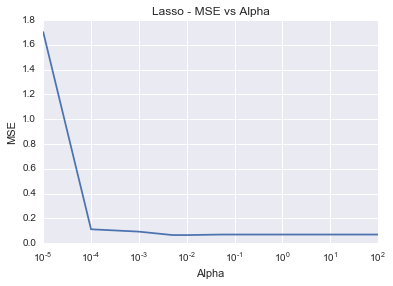

In [81]:
lasso_model = Lasso()
alphas         = [ 1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 10, 100 ]
lasso_mses     = []
lasso_avg_mses = []
lasso_std_mses = []

for alpha in alphas:
    lasso_model.alpha = alpha
    scores = cross_val_score(lasso_model, X_scale, y, scoring='neg_mean_squared_error', cv=5)
    lasso_mses.append( scores*-1 )
    lasso_avg_mses.append( -scores.mean() )
    lasso_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, lasso_avg_mses )
plt.title('Lasso - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

min_mse = min(lasso_avg_mses)
min_mse_index = lasso_avg_mses.index(min(lasso_avg_mses))
min_std_index = lasso_std_mses.index(min(lasso_std_mses))

if min_mse_index == min_std_index:
    best_index = min_mse_index
else:
    if abs(lasso_avg_mses[min_mse_index] - lasso_avg_mses[min_std_index]) < 0.01*lasso_avg_mses[min_mse_index]:
        best_index = min_std_index    
    else:
        best_index = min_mse_index
            
    

print("Average MSE (alpha = %0.3f): %0.4f (+/- %0.4f)" % (alphas[best_index],lasso_avg_mses[best_index], lasso_std_mses[best_index]))

The whole purpose of the above is to find the optimal alpha (the penalty). For each different alpha the model has a different performance. In the plot above we are measuring the mean squared error of the model for each alpha we tested. The lower the error the better the alpha. Alpha in this case was selected to be 0.005  
  
Now we are going to perform the same cross validation procedue to find the optimal alpha for Ridge Regression.

Average MSE (alpha = 100.000): 0.0654 (+/- 0.0142)


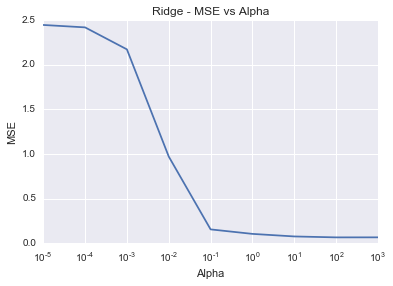

In [85]:
ridge_model = Ridge()
alphas         = [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100,1000 ]
ridge_mses     = []
ridge_avg_mses = []
ridge_std_mses = []

for alpha in alphas:
    ridge_model.alpha = alpha
    scores = cross_val_score(ridge_model, X_scale, y, scoring='neg_mean_squared_error', cv=5)
    ridge_mses.append( scores*-1 )
    ridge_avg_mses.append( -scores.mean() )
    ridge_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, ridge_avg_mses )
plt.title('Ridge - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')



min_mse = min(ridge_avg_mses)
min_mse_index = ridge_avg_mses.index(min(ridge_avg_mses))
min_std_index = ridge_std_mses.index(min(ridge_std_mses))

if min_mse_index == min_std_index:
    best_index = min_mse_index
else:
    if abs(lasso_avg_mses[min_mse_index] - lasso_avg_mses[min_std_index]) < 0.01*lasso_avg_mses[min_mse_index]:
        best_index = min_std_index    
    else:
        best_index = min_mse_index

# print('MSEs (alpha = 1e-2):', lasso_mses[3]*-1)
print("Average MSE (alpha = %0.3f): %0.4f (+/- %0.4f)" % (alphas[best_index],ridge_avg_mses[best_index], ridge_std_mses[best_index]))

For Ridge Regression we found the model to perform best with an alpha = 100